# Data analysis for simulation
## The simulation problem:
### Police Car Maintenance Garage

Hobbiton city council owns and operates a garage in which maintenance and repair work is performed on the city’s police car fleet.

The garage has made available four datasets:

- The number of scheduled cars that arrived for service each day, in batches of 2,3 or 4 (ArrivalScheduled.csv)
- The time required to service scheduled vehicles (ServiceScheduled.csv)
- The date and time that each unscheduled service police car arrived (ArrivalUnscheduled.csv)
- The time required to service unscheduled vehicles (ServiceUnscheduled.csv)

## Exoplore the datasets

ArrivalScheduled.csv ['Date', 'Day', 'Number of cars']
<class 'pandas.core.series.Series'> 
 0      4
1      3
2      4
3      2
4      4
      ..
360    3
361    3
362    4
363    2
364    3
Name: Number of cars, Length: 365, dtype: int64 



,Number of cars
count,365.000000
mean,2.980822
std,0.700992
min,2.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


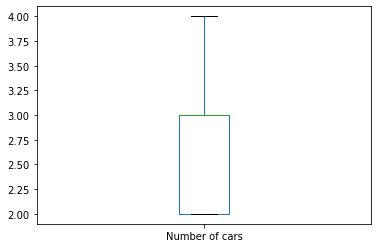

In [48]:
import pandas as pd

# Load data from CSV:

# [1] Arrivals - Scheduled (as)
file_name_as = u'ArrivalScheduled.csv'
as_data = pd.read_csv(file_name_as, sep=',')
column_names_as = as_data.columns.tolist()

# Illustrate data and usefull information
print(file_name_as, column_names_as)
print(type(as_data['Number of cars']),'\n', as_data['Number of cars'],'\n')
display(pd.DataFrame(as_data['Number of cars'].describe()))
boxplot = as_data.boxplot(column=['Number of cars'], grid=False)

ArrivalUnscheduled.csv ['UnscheduledArrivals']
<class 'pandas.core.series.Series'> 
 1      40.0
2      54.0
3      46.0
4      46.0
5      49.0
       ... 
179    49.0
180    48.0
181    46.0
182    48.0
183    45.0
Name: deltaT, Length: 183, dtype: float64 



,deltaT
count,184.000000
mean,47.603261
std,7.759372
min,0.000000
25%,43.000000
50%,48.000000
75%,53.000000
max,69.000000


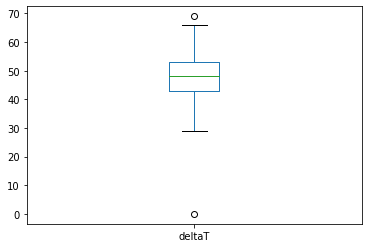

In [47]:
# [2] Arrivals - Unscheduled (au)
file_name_au = u'ArrivalUnscheduled.csv'
au_data = pd.read_csv(file_name_au, sep=',')
column_names_au = au_data.columns.tolist()

# Convert to pandas datetime format (format='%m/%d/%Y %I:%M')
au_data['datetime'] = pd.to_datetime(au_data['UnscheduledArrivals'], errors='coerce', dayfirst = [True]) 

# Sort the dataframe by date
au_data = au_data.sort_values(by='datetime')

# Calculate the inter-arrivals
au_data['deltaT'] = ((au_data['datetime']-au_data['datetime'].shift())/60).astype('timedelta64[m]').fillna(0)
deltaT = au_data['deltaT'][1:]

# Illustrate data and usefull information
print(file_name_au, column_names_au)
print(type(deltaT),'\n', deltaT,'\n')
display(pd.DataFrame(au_data['deltaT'].describe()))
boxplot = au_data.boxplot(column=['deltaT'], grid=False)

ServiceScheduled.csv ['timeinhours']
<class 'pandas.core.series.Series'> 
 0    2.031513
1    1.984567
2    1.937508
3    1.501078
4    1.728006
5    1.823221
6    1.952461
7    2.063018
8    2.326856
9    2.495684
Name: timeinhours, dtype: float64 



,timeinhours
count,1000.000000
mean,1.999073
std,0.289429
min,1.501078
25%,1.747178
50%,2.007252
75%,2.242609
max,2.499693


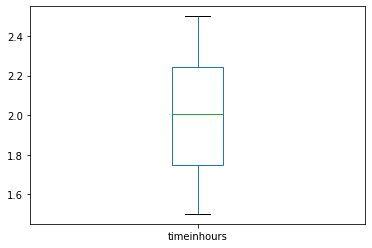

In [32]:
# [3] Service - Scheduled (ss) # MAYBE first round the data to be either 0.5, 1.5, 2...
file_name_ss = u'ServiceScheduled.csv'
ss_data = pd.read_csv(file_name_ss, sep=' ')
column_names_ss = ss_data.columns.tolist()
ss_data = ss_data[column_names_ss[0]].astype(float)

# Illustrate data and usefull information
print(file_name_ss, column_names_ss)
print(type(ss_data),'\n', ss_data[:10],'\n')
display_ss = pd.DataFrame(ss_data)
display(display_ss.describe())
boxplot = display_ss.boxplot(column=['timeinhours'], grid=False)

ServiceUnscheduled.csv ['timeinhours']
<class 'pandas.core.series.Series'> 
 0    0.858453
1    8.519445
2    0.581225
3    7.671357
4    0.847853
5    2.205484
6    2.215184
7    0.946615
8    6.913811
9    7.284312
Name: timeinhours, dtype: float64 



,timeinhours
count,1000.000000
mean,2.336943
std,2.279964
min,0.004620
25%,0.686649
50%,1.604809
75%,3.334727
max,16.066764


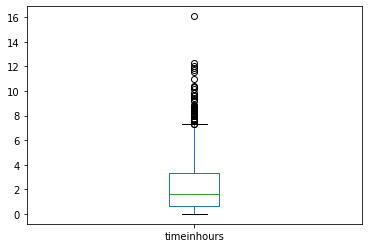

In [44]:
# [4] Service - Unscheduled (su)
file_name_su = u'ServiceUnscheduled.csv'
su_data = pd.read_csv(file_name_su, sep=' ')
column_names_su = su_data.columns.tolist()
su_data = su_data[column_names_su[0]].astype(float)

# Illustrate data and usefull information
print(file_name_su, column_names_su)
print(type(su_data),'\n', su_data[:10],'\n')
display_su = pd.DataFrame(su_data)
display(display_su.describe())
boxplot = display_su.boxplot(column=['timeinhours'], grid=False)

In [46]:
# Print the outlier value shown in the boxplot
display_su[display_su.timeinhours > 14]

,timeinhours
140,16.066764


Although the outlier is significantly greater than the other values in the data. It can be considered that this value represents a rare mechanical breakdown which actualy takes a long time to repair. The alternative scenario is that there was a false time evaluation during that pricedure. Regarding the first scenario, I decided **not** to **remove** the outlier value.

## Find the best fitting distribution for each dataset
A distribution which fits the actual data will allow us to interminably generate numbers based on that distribution; in a specific range of values or with specific constraints so that the new values are similar to the already occupied from the dataset values.

The following code creates a histogram of the given data and then attempts to fit every distribution given in the 'DISTRIBUTIONS' list with finding the optimal parameters. It then calculates and outputs the name of the best fitting distribution of those tested together with its optimal parameters.

In [2]:
import warnings
import numpy as np
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    
    DISTRIBUTIONS = [        
        st.norm, st.triang, st.uniform, st.expon, st.erlang, st.lognorm, st.gamma, st.beta,
        st.pearsonr, st.poisson, st.triang, st.binom, st.nbinom, st.bernoulli, st.geom, st.pearson3
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def plot_fitted_distribution (data, file_name, data_name):
    # Assign the imported data to those to be used
    #data = arrival_unscheduled_data

    # Load data from statsmodels datasets
    #import statsmodels as sm
    #data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'\n All Fitted Distributions for ' + file_name)
    ax.set_xlabel(data_name)
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(file_name + u' with best fit distribution \n' + dist_str)
    ax.set_xlabel(data_name)
    ax.set_ylabel('Frequency')

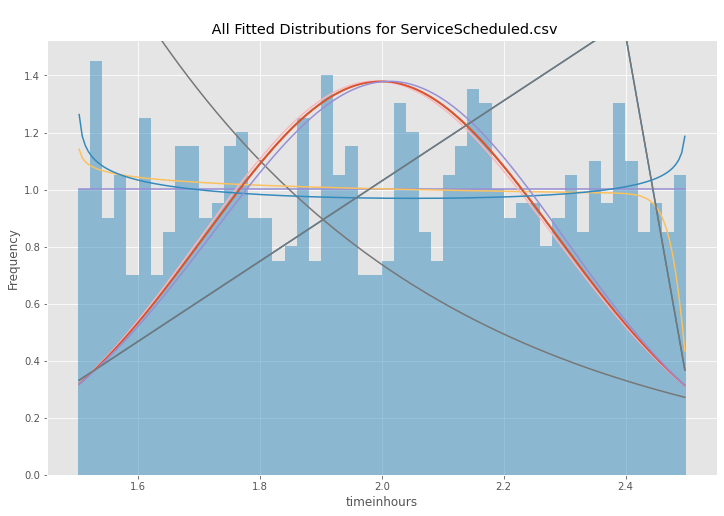

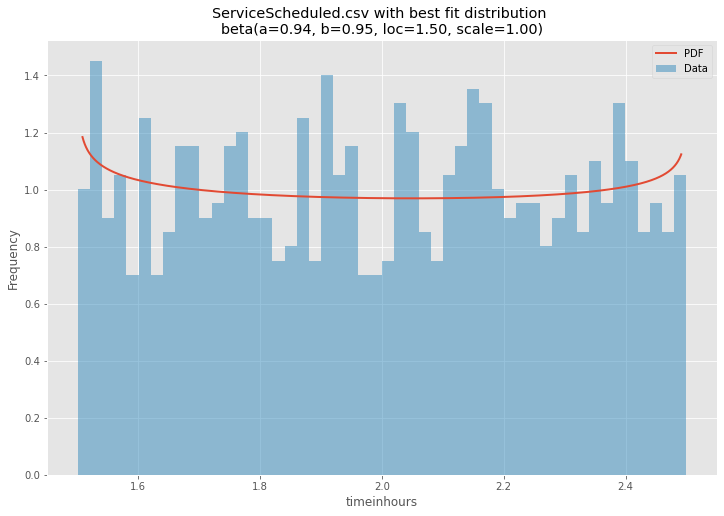

In [9]:
plot_fitted_distribution(ss_data, file_name_ss, column_names_ss[0])
# for beta distribution of scipy : α, β, loc (lower limit), scale (upper limit - lower limit)

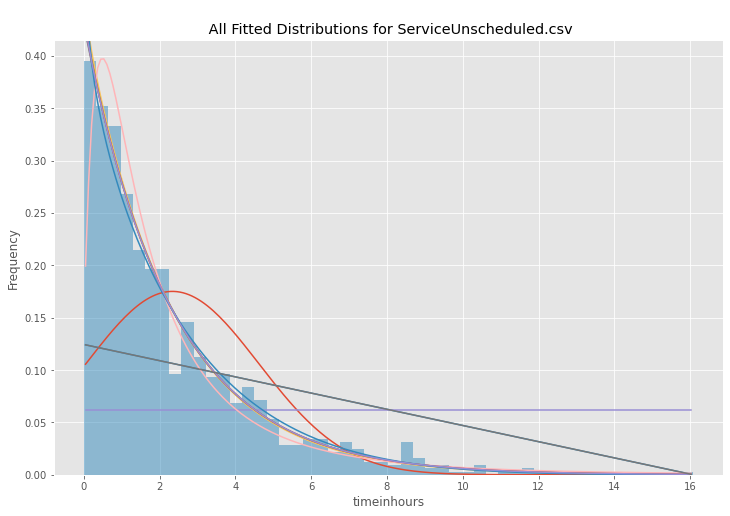

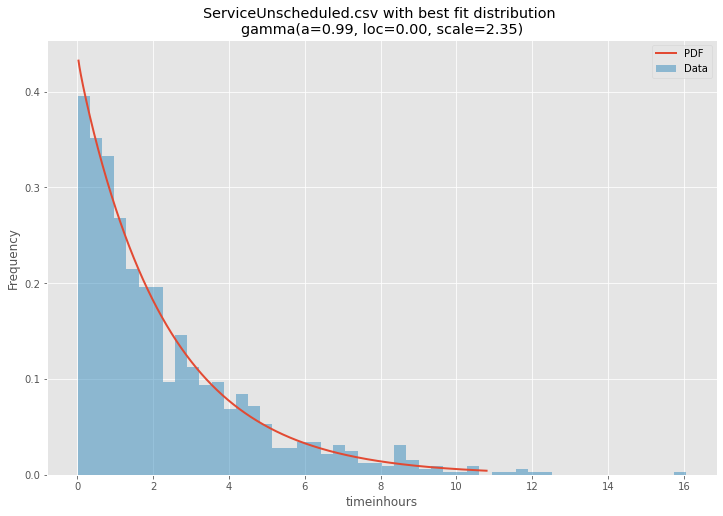

In [10]:
plot_fitted_distribution(su_data, file_name_su, column_names_su[0])
# For gamma distribution, Alpha = a, Beta = Scale

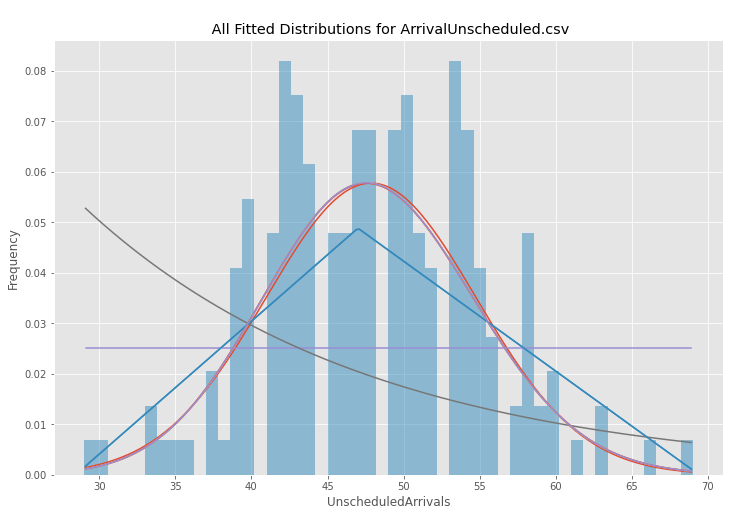

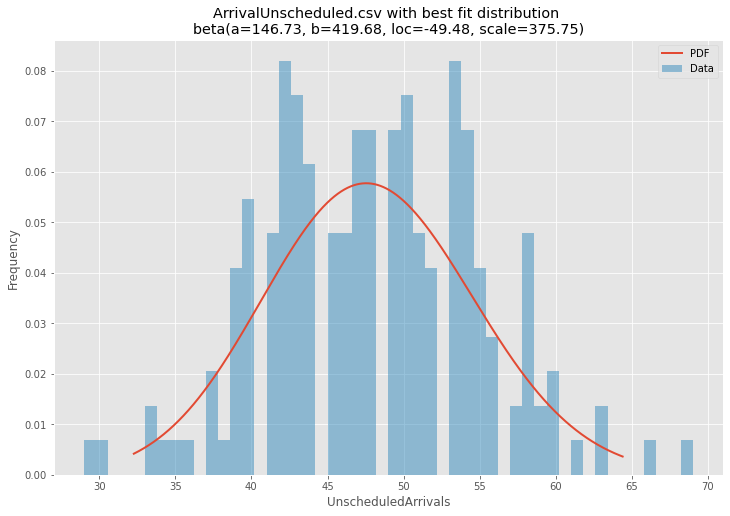

In [17]:
plot_fitted_distribution(deltaT, file_name_au, column_names_au[0])

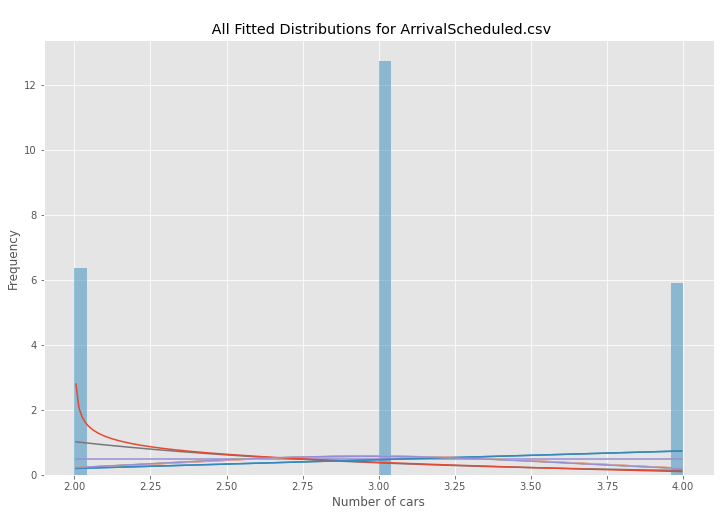

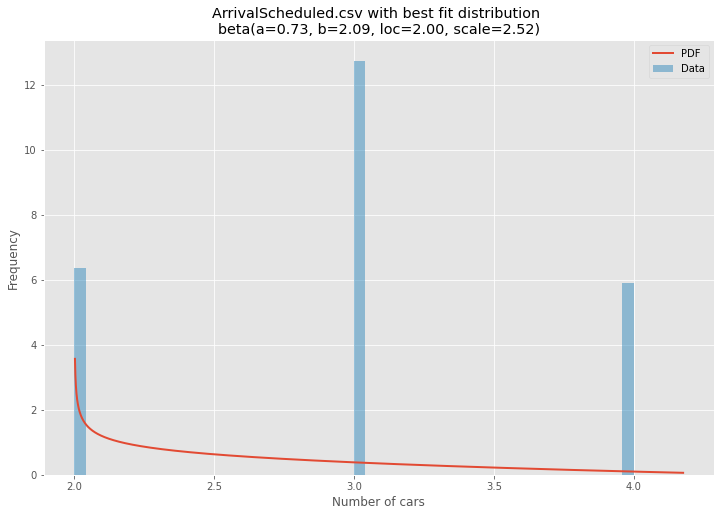

In [17]:
plot_fitted_distribution(as_data['Number of cars'], file_name_as, column_names_as[2])

The histogram above is a three-value histogram which makes it hard for our algorithm to find a well fitted distribution. This type of histograms/data are often described using a probabilistic, discrete distribution, as it is also easy to calculate. As shown below we need to calculate the percentage probability in which every of the three values occur.

In [7]:
# Calculate the probability for every batching value (2,3 or 4)
(as_data['Number of cars'].value_counts(normalize=True))*100

3    50.958904
2    25.479452
4    23.561644
Name: Number of cars, dtype: float64